In [180]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils


OBSERVER_TYPE = "gaussian"
LESION_PCT = 0.75
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_MODULE_ID = "F5"
OBS_OUT_DIM = 64
NUM_STIM_CHANNELS = 60
BATCH_SIZE = 96

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _, drop_module_idx = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_pct=LESION_PCT,
                                              lesion_module_id=LESION_MODULE_ID,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=35,
                                              obs_out_dim=OBS_OUT_DIM)

CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
# Set up the Michaels mRNN

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path())
mike.set_lesion(lesion_instance)
mike.reset()

In [182]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(), with_label=True)

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 1])


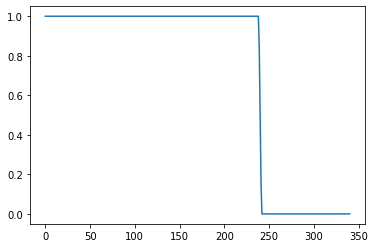

In [120]:
# Hold signal is in the last position
plt.plot(dataset[0][0][:, -1:].detach().numpy())
print(dataset[0][0][:, -1:].shape)
plt.show()

In [44]:
# Question 1: can we find the hold signal?

loss = torch.nn.MSELoss()
model = utils.LSTMModel(OBS_OUT_DIM * 2, 1, num_neurons=OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=2e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 1e-3:
    for batch in loader:
        if ll < 0.1:
            for p in opt.param_groups:
                p['lr'] = 1e-4
        if ll < 0.02:
            for p in opt.param_groups:
                p['lr'] = 3e-5
                
        opt.zero_grad()
        
        din, trial_end, trial_len, dout, dlabel = batch
        steps = din.shape[1]
        batch_size = din.shape[0]
        
        dvis = din[:, :, :-1]
        dhold = din[:, :, -1:]
        
        mike.reset()
        model.reset()
        
        preds = torch.zeros(batch_size, steps, 1)
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer, drop_module_idx=1)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
            preds[:, tidx, :] = pred[:, :]
        
        la = loss(preds, dhold)
        la.backward()
        opt.step()
        ll = la.item()
        print(eidx, ll)
        
        eidx += 1

        
        break
    break
        
        
# Yes. That works

0 0.017514115199446678


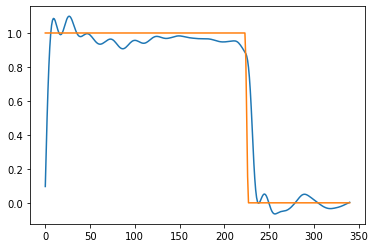

In [45]:
plt.plot(preds[1, :, 0].detach().numpy())
plt.plot(dhold[1, :, 0].detach().numpy())
plt.show()

In [ ]:
# Question 2: can we separate the classes?

loss = nn.CrossEntropyLoss()
model = utils.LSTMModel(OBS_OUT_DIM * 3, 7, num_neurons=3*OBS_OUT_DIM)
opt = AdamW(model.parameters(), lr=1e-3)
ll = 1

for param in mike.parameters():
    param.requires_grad=False
    
eidx = 0
while ll > 0.5:
    for batch in loader:
        opt.zero_grad()
        if ll >= 1.6:
            for p in opt.param_groups:
                p['lr'] = 1e-3
        elif ll < 1.6:
            for p in opt.param_groups:
                p['lr'] = 7e-6
        elif ll < 1.3:
            for p in opt.param_groups:
                p['lr'] = 5e-6
        elif ll < 0.5:
            for p in opt.param_groups:
                p['lr'] = 3e-6
        
        din, trial_end, trial_len, dout, dlabel = batch
        
        # Let's actually see if the early trial info is enough...
        #steps = din.shape[1]
        steps = 231
        batch_size = din.shape[0]
                
        mike.reset()
        model.reset()
        for tidx in range(steps):
            mike_in = din[:, tidx, :].T
            mike(mike_in)
            
            obs = mike.observe(observer)#, drop_module_idx=1)
            new_obs = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
            pred = model(new_obs)
        
        la = loss(pred, dlabel)
        ll = la.item()

        
        correct = 0
        for x in range(batch_size):
            m = torch.argmax(pred[x, :])
            if m == dlabel[x]:
                correct += 1
        print(eidx, f"{correct}/{batch_size}", la.item())
        
        eidx += 1
        if ll >= (la.item() * 0.8):
            la.backward()
            opt.step()
        ll = la.item()



0 8/96 1.9488554000854492
1 12/96 1.9458357095718384
2 11/96 1.9546185731887817
3 14/96 1.9579073190689087
4 13/96 1.9440709352493286
5 2/22 1.9573192596435547
6 17/96 1.9442964792251587
7 25/96 1.942487359046936
8 13/96 1.948097586631775
9 13/96 1.9452944993972778
10 13/96 1.9453121423721313
11 5/22 1.9381325244903564
12 13/96 1.9435487985610962
13 15/96 1.942093014717102
14 14/96 1.94662344455719
15 12/96 1.951521873474121
16 14/96 1.9418258666992188
17 4/22 1.9388947486877441
18 7/96 1.9482229948043823
19 15/96 1.9429006576538086
20 26/96 1.935275673866272
21 16/96 1.9419387578964233
22 8/96 1.9488414525985718


In [113]:
correct = 0
for x in range(batch_size):
    m = torch.argmax(pred[x, :])
    if m == dlabel[x]:
        correct += 1
print(correct)

62


In [136]:
print(new_obs[0, 40:])

tensor([2.2968e-05, 3.3119e-01, 2.4881e-01, 6.2111e-03, 2.5865e-02, 1.6499e-01,
        2.8937e-01, 2.9962e-01, 1.8222e-01, 1.4834e-01, 9.6375e-02, 2.0563e-02,
        1.1619e-01, 4.6002e-01, 4.8300e-02, 3.7242e-02, 1.8442e-02, 1.7884e-01,
        2.0003e-01, 1.5599e-01])


In [ ]:
#1.29 on obs dim 45 / 50% lesion